<img src="../images/bikes_banner.jpg" width="1000" />

# <span style="color:#37535e">Bicycle Share Usage</span>

##  <span style='color:#3b748a'>Plotting data from all cities.</span>

<span style='color:#4095b5'>This notebook explores the bike rental, bike, weather, and daylight data for six cities: Atlanta, Boston, Chicago, Los Angeles, Philadelphia, and San Franciso.</span>


## <span style='color:#3b748a'>Table of contents</span>
<ul>
    <li><span style='color:#4095b5'><a href="#import"><span style='color:#4095b5'>I. Import rental data.</span></a></span></li>
    <li><span style='color:#4095b5'><a href="#plot"><span style='color:#4095b5'>II. Plot rental data.</span></a></span></li>
    <li><span style='color:#4095b5'><a href="#import_bikes"><span style='color:#4095b5'>III. Import bike data.</span></a></span></li>
    <li><span style='color:#4095b5'><a href="#plot_bikes"><span style='color:#4095b5'>IV. Plot bike data.</span></a></span></li>
    <li><span style='color:#4095b5'><a href="#import_daylight"><span style='color:#4095b5'>V. Import daylight data.</span></a></span></li>
    <li><span style='color:#4095b5'><a href="#plot_daylight"><span style='color:#4095b5'>VI. Plot daylight data.</span></a></span></li>
</ul>

## <span style='color:#3b748a'>External data required</span>
<ul>
    <li><span style='color:#4095b5'>../data/&lt;city&gt;/daily.csv (available in GitHub)</span></li>
    <li><span style='color:#4095b5'>../data/&lt;city&gt;/bike.csv (available in GitHub)</span></li>
    <li><span style='color:#4095b5'>../data/&lt;city&gt;/daylight.csv (available in GitHub)</span></li>
</ul>

## <span style='color:#3b748a'>Links</span>
<ul>
    <li><a href="daylight.ipynb"><span style='color:#4095b5'>Daylight data</span></a></li>
</ul>
<hr>

In [1]:
# Let's get the administrative stuff done first
# import all the libraries and set up the plotting

import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from geopy.distance import vincenty

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
colors_palette = sns.color_palette("Paired", 10)
sns.set_palette(colors_palette)
%matplotlib inline

# GnBu_d
colors = ['#37535e', '#3b748a', '#4095b5', '#52aec9', '#72bfc4', '#93d0bf']

<hr>
<a name="import"> </a>
## <span style='color:#3b748a'>I. Import daily data.</span>

In [2]:
# Crazy order to help color palette
city_codes = { 
    'bos' : "Boston", 
#    'nyc' : "New York",
    'la' : "Los Angeles", 
    'sf' : "San Francisco", 
    'chi' : "Chicago", 
    'phl' : "Philadelphia", 
#    'dc' : "DC",
    'atl' : "Atlanta" 
        }

 ### <span style='color:#4095b5'>Create a "daily summary" DataFrame containing all cities</span>

In [3]:
df_daily = pd.DataFrame()

for city, city_name in city_codes.items():
    df_temp = pd.read_csv('../data/' + city + '/daily.csv')
    df_temp['City'] = city
    df_daily = df_daily.append(df_temp)

In [4]:
# Type cast must happen after reading from csv
df_daily['Start Date'] = pd.to_datetime(df_daily['Start Date'])


In [5]:
df_daily.head()

,Start Date,Total Duration,Trips,Total Distance,Avg Duration,Avg Distance,events,hum_avg,prec,temp_avg,wind_avg,Daylight,Date,Day,DayOfYear,Week,Month,Year,City
0,2017-09-01,94803.383333,5628,6839.222300,16.844951,1.215214,None,43,0.00,61,15,788.766667,1504224000000000000,5,244,35,9,2017,bos
1,2017-09-02,108006.533333,4348,5110.919159,24.840509,1.175464,None,51,0.00,61,10,786.016667,1504310400000000000,6,245,35,9,2017,bos
2,2017-09-03,17343.450000,1124,1208.701863,15.430116,1.075358,Rain,82,0.28,61,13,783.266667,1504396800000000000,0,246,35,9,2017,bos
3,2017-09-04,121930.983333,5071,5850.874424,24.044761,1.153791,None,68,0.00,70,14,780.500000,1504483200000000000,1,247,36,9,2017,bos
4,2017-09-05,92226.850000,6235,7582.731958,14.791796,1.216156,None,72,0.00,77,17,777.733333,1504569600000000000,2,248,36,9,2017,bos


 ### <span style='color:#4095b5'>Create dataframes grouped by different time periods</span>

In [6]:
def groupby_period(period, df):
    df_period = df.groupby([period, 'City'], as_index=False).agg({
        "Total Duration" : ['sum'],
        "Total Distance" : ['sum'],
        "Trips" : ['sum'],
        "Avg Duration" : ['mean'],
        "Avg Distance" : ['mean'],
        "hum_avg" : ['mean'],
        "prec" : ['mean'],
        "temp_avg" : ['mean'],
        "wind_avg" : ['mean']
    })

    df_period.columns = ["_".join(x) for x in df_period.columns.ravel()]
    df_period.rename(columns={
        period+'_' : period,
        'City_': 'City', 
        'Total Duration_sum': 'Total Duration', 
        'Total Distance_sum': 'Total Distance', 
        'Trips_sum'         : 'Trips',
        'Avg Duration_mean' : 'Avg Duration',
        'Avg Distance_mean' : 'Avg Distance',
        'hum_avg_mean'      : 'Avg Humidity',
        'prec_mean'         : 'Avg Prec',
        'temp_avg_mean'     : 'Avg Temp',
        'wind_avg_mean'     : 'Avg Wind'
    }, inplace=True)
    
    return df_period

 #### <span style='color:#4095b5'>Create dataframes grouped by month, week, and day of week</span>

In [7]:
df_month = groupby_period('Month', df_daily)
df_week = groupby_period('Week', df_daily)
df_day = groupby_period('Day', df_daily)

In [8]:
df_week.head()

,Week,City,Total Duration,Total Distance,Trips,Avg Duration,Avg Distance,Avg Humidity,Avg Prec,Avg Temp,Avg Wind
0,1,atl,8879.966667,649.610000,404,21.872966,1.587821,43.714286,0.001429,28.571429,10.428571
1,1,bos,33904.083333,2704.623856,2556,15.132899,1.007788,54.142857,0.192857,14.000000,17.714286
2,1,chi,105998.016667,10153.430923,10620,10.338712,0.945327,60.714286,0.005714,6.857143,11.142857
3,1,la,192402.000000,3974.128923,4823,39.674554,0.823382,65.857143,0.000000,63.428571,0.714286
4,1,phl,52409.000000,2377.182496,2474,28.023287,0.924007,48.571429,0.035714,16.428571,14.000000


<hr>
<a name="process"> </a>
## <span style='color:#3b748a'>II. Process daily data.</span>

In [9]:
# Setup
color_line = colors[1]
color_dist = colors[2]
color_box = colors[3]

days_of_week = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday' ]

 #### <span style='color:#4095b5'>Statistics on day of week</span>

In [10]:
# For each day (365 days from sep 2017 - aug 2018)
df_daily['Trips'].describe()

count     2190.000000
mean      3561.526027
std       4250.071370
min          1.000000
25%        709.500000
50%       2116.500000
75%       4619.500000
max      21617.000000
Name: Trips, dtype: float64

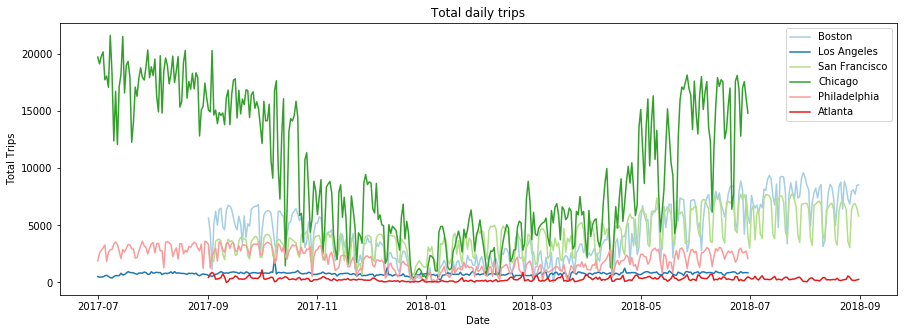

In [11]:
# Total trips per day
plt.figure(figsize=(15,5))
legend = []
for city, city_name in city_codes.items():
    df_city = df_daily[df_daily['City'] == city]
    plt.plot(df_city['Start Date'], df_city['Trips'])
    legend.append(city_name)

ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Total Trips")
ax.set_title("Total daily trips")
plt.legend(legend, loc='upper right');

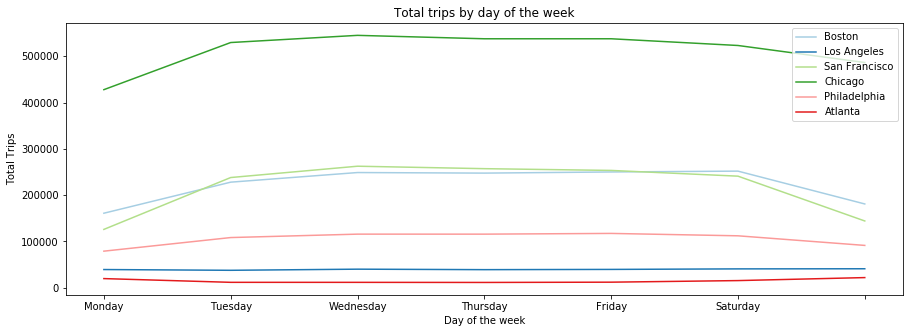

In [12]:
# Total trips per day
plt.figure(figsize=(15,5))
legend = []
for city, city_name in city_codes.items():
    df_city = df_day[df_day['City'] == city]
    plt.plot(df_city['Day'], df_city['Trips'])
    legend.append(city_name)

ax = plt.gca()
ax.set_xlabel("Day of the week")
ax.set_xticklabels(days_of_week)
ax.set_ylabel("Total Trips")
ax.set_title("Total trips by day of the week")
plt.legend(legend, loc='upper right');

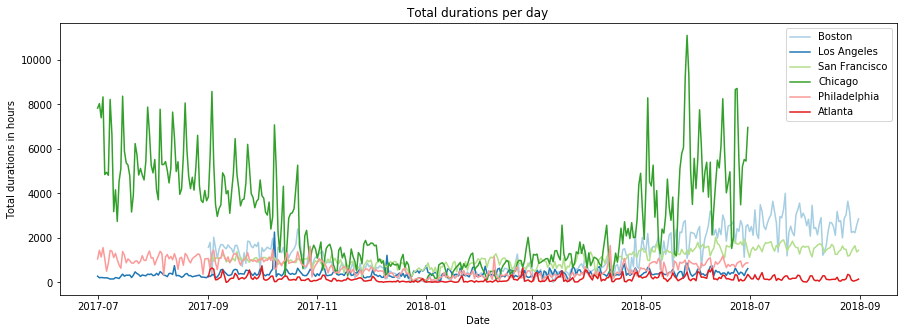

In [13]:
# Total durations per day
plt.figure(figsize=(15,5))
legend = []
for city, city_name in city_codes.items():
    df_city = df_daily[df_daily['City'] == city]
    plt.plot(df_city['Start Date'], df_city['Total Duration']/60)
    legend.append(city_name)

ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Total durations in hours")
ax.set_title("Total durations per day")
plt.legend(legend, loc='upper right');


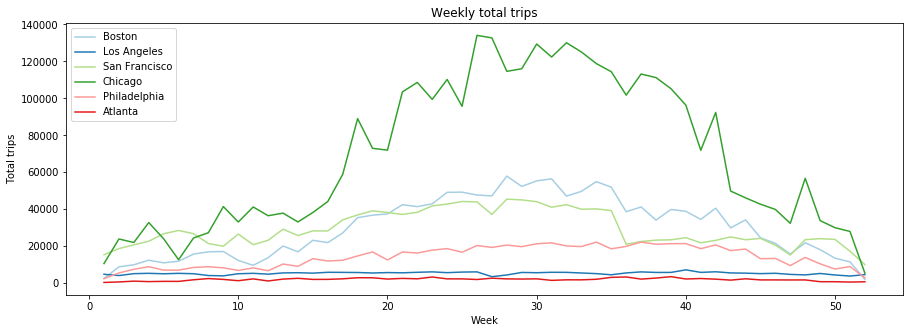

In [14]:
# Total trips per week
plt.figure(figsize=(15,5))
legend = []
for city, city_name in city_codes.items():
    df_city = df_week[df_week['City'] == city]
    plt.plot(df_city['Week'], df_city['Trips'])
    legend.append(city_name)

ax = plt.gca()
ax.set_xlabel("Week")
ax.set_ylabel("Total trips")
ax.set_title("Weekly total trips")
plt.legend(legend, loc='upper left');

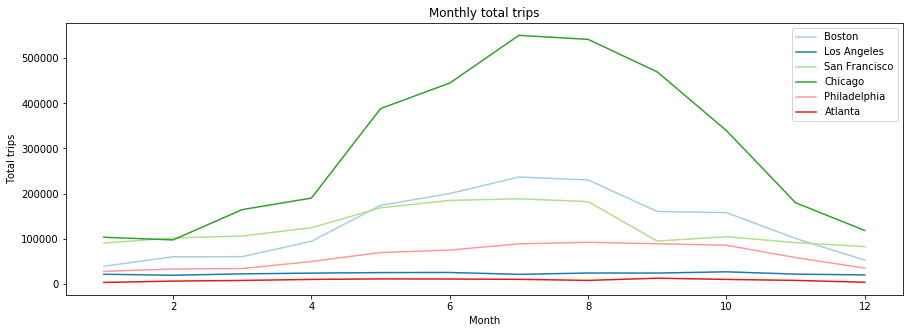

In [15]:
# Total trips per month
plt.figure(figsize=(15,5))
legend = []
for city, city_name in city_codes.items():
    df_city = df_month[df_month['City'] == city]
    plt.plot(df_city['Month'], df_city['Trips'])
    legend.append(city_name)

ax = plt.gca()
ax.set_xlabel("Month")
ax.set_ylabel("Total trips")
ax.set_title("Monthly total trips")
plt.legend(legend, loc='upper right');

<hr>
<a name="import_bike"> </a>
## <span style='color:#3b748a'>III. Import bike data.</span>

In [16]:
# Read data from each city into one dataframe
df_bikes = pd.DataFrame()

for city, city_name in city_codes.items():
    df_temp = pd.read_csv('../data/' + city + '/bikes.csv')

    df_temp["City"] = city
    df_bikes = df_bikes.append(df_temp)

df_bikes.shape

(17648, 7)

In [17]:
df_bikes.head()

,Bike Name,Total Duration,Avg Duration,Trips,Total Distance,Avg Distance,City
0,1,10365.933333,18.059117,574,711.915308,1.240271,bos
1,2,3218.250000,23.490876,137,180.134450,1.314850,bos
2,3,12451.566667,20.547140,606,709.619555,1.170989,bos
3,4,12227.033333,16.067061,761,924.944497,1.215433,bos
4,5,8642.050000,13.849439,624,651.594268,1.044222,bos


<hr>
<a name="process_bike"> </a>
## <span style='color:#3b748a'>IV. Process bike data.</span>

<hr>
<a name="import_daylight"> </a>
## <span style='color:#3b748a'>V. Import daylight data.</span>

In [18]:
# Crazy order to help color palette
city_codes = { 
    'bos' : "Boston", 
    'nyc' : "New York",
    'la' : "Los Angeles", 
    'sf' : "San Francisco", 
    'chi' : "Chicago", 
    'phl' : "Philadelphia", 
    'dc' : "DC",
    'atl' : "Atlanta" 
        }

In [19]:
# Read data from each city into one dataframe
df_daylight = pd.DataFrame()

for city, city_name in city_codes.items():
    df_temp = pd.read_csv('../data/' + city + '/daylight.csv')
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    df_temp['Daylight'] = pd.to_timedelta(df_temp['Daylight'], unit='m')
    # Hours of light
    df_temp['Daylight'] = (df_temp['Daylight'].dt.total_seconds()/3600)

    df_temp["City"] = city
    df_daylight = df_daylight.append(df_temp)

# Only take sep 2017 - aug 2018
df_daylight = df_daylight[df_daylight['Date'] >= datetime.strptime('2017-09-01 00:00:00', '%Y-%m-%d %H:%M:%S')].copy()
df_daylight = df_daylight[df_daylight['Date'] < datetime.strptime('2018-09-01 00:00:00', '%Y-%m-%d %H:%M:%S')].copy()
df_daylight.rename(columns={'Date': 'Start Date'}, inplace=True)


<hr>
<a name="process_daylight"> </a>
## <span style='color:#3b748a'>V. Process daylight data.</span>

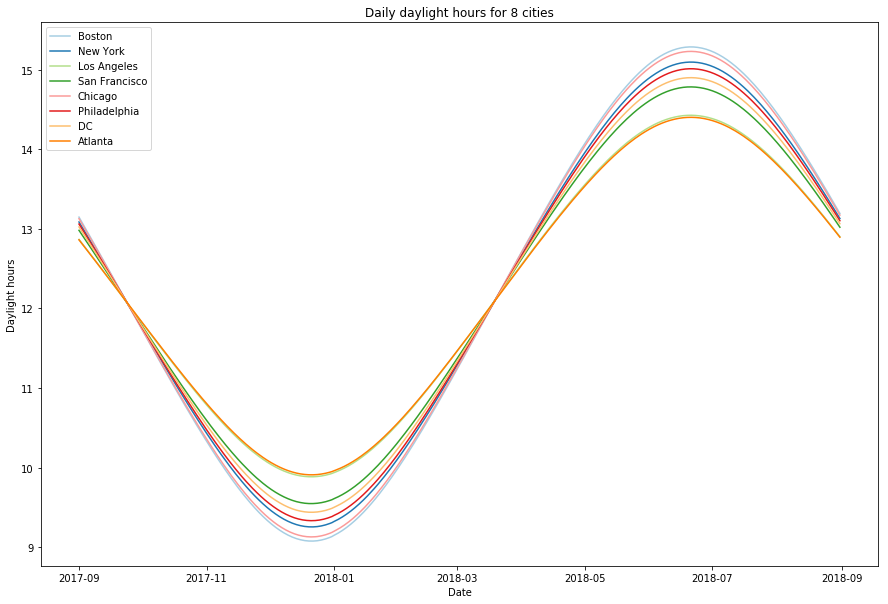

In [20]:
plt.figure(figsize=(15,10))
legend = []
for city, city_name in city_codes.items():
    df_city = df_daylight[df_daylight['City'] == city]
    plt.plot(df_city['Start Date'], df_city['Daylight'])
    legend.append(city_name)

ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Daylight hours")
ax.set_title("Daily daylight hours for 8 cities")
plt.legend(legend, loc='upper left');


In [21]:
df_week.head()

,Week,City,Total Duration,Total Distance,Trips,Avg Duration,Avg Distance,Avg Humidity,Avg Prec,Avg Temp,Avg Wind
0,1,atl,8879.966667,649.610000,404,21.872966,1.587821,43.714286,0.001429,28.571429,10.428571
1,1,bos,33904.083333,2704.623856,2556,15.132899,1.007788,54.142857,0.192857,14.000000,17.714286
2,1,chi,105998.016667,10153.430923,10620,10.338712,0.945327,60.714286,0.005714,6.857143,11.142857
3,1,la,192402.000000,3974.128923,4823,39.674554,0.823382,65.857143,0.000000,63.428571,0.714286
4,1,phl,52409.000000,2377.182496,2474,28.023287,0.924007,48.571429,0.035714,16.428571,14.000000


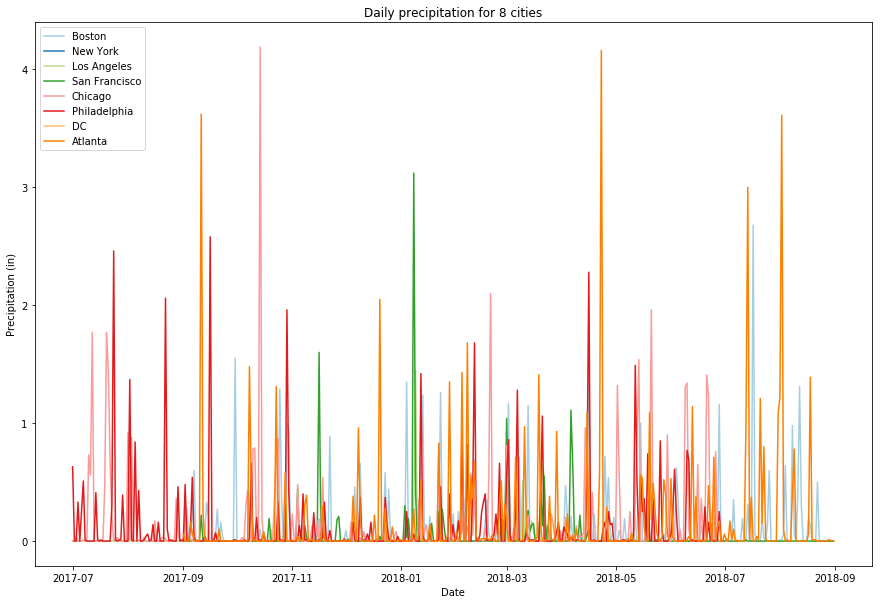

In [22]:
plt.figure(figsize=(15,10))
legend = []
for city, city_name in city_codes.items():
    df_city = df_daily[df_daily['City'] == city]
    plt.plot(df_city['Start Date'], df_city['prec'])
    legend.append(city_name)

ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (in)")
ax.set_title("Daily precipitation for 8 cities")
plt.legend(legend, loc='upper left');


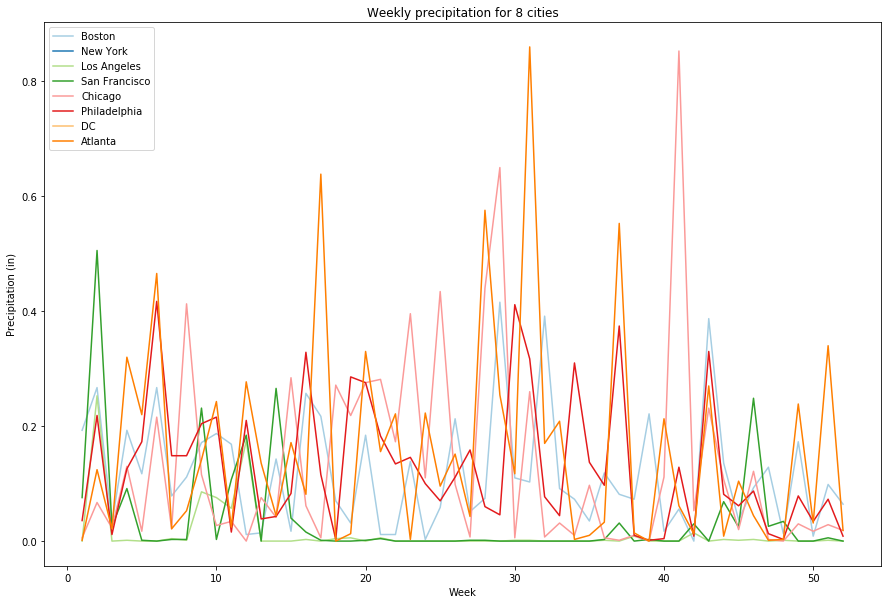

In [24]:
plt.figure(figsize=(15,10))
legend = []
for city, city_name in city_codes.items():
    df_city = df_week[df_week['City'] == city]
    plt.plot(df_city['Week'], df_city['Avg Prec'])
    legend.append(city_name)

ax = plt.gca()
ax.set_xlabel("Week")
ax.set_ylabel("Precipitation (in)")
ax.set_title("Weekly precipitation for 8 cities")
plt.legend(legend, loc='upper left');


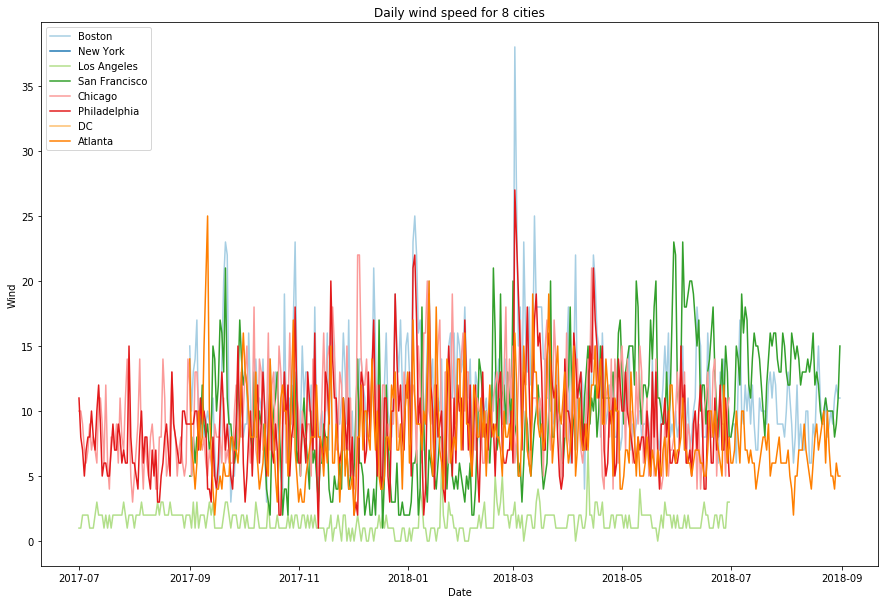

In [27]:
plt.figure(figsize=(15,10))
legend = []
for city, city_name in city_codes.items():
    df_city = df_daily[df_daily['City'] == city]
    plt.plot(df_city['Start Date'], df_city['wind_avg'])
    legend.append(city_name)

ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Wind sped (mph)")
ax.set_title("Daily wind speed for 8 cities")
plt.legend(legend, loc='upper left');


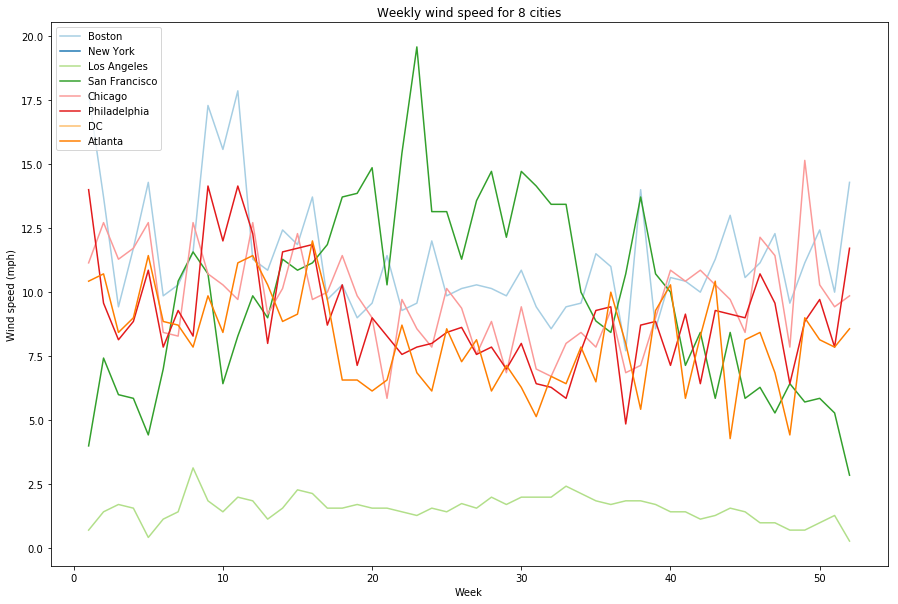

In [28]:
plt.figure(figsize=(15,10))
legend = []
for city, city_name in city_codes.items():
    df_city = df_week[df_week['City'] == city]
    plt.plot(df_city['Week'], df_city['Avg Wind'])
    legend.append(city_name)

ax = plt.gca()
ax.set_xlabel("Week")
ax.set_ylabel("Wind speed (mph)")
ax.set_title("Weekly wind speed for 8 cities")
plt.legend(legend, loc='upper left');


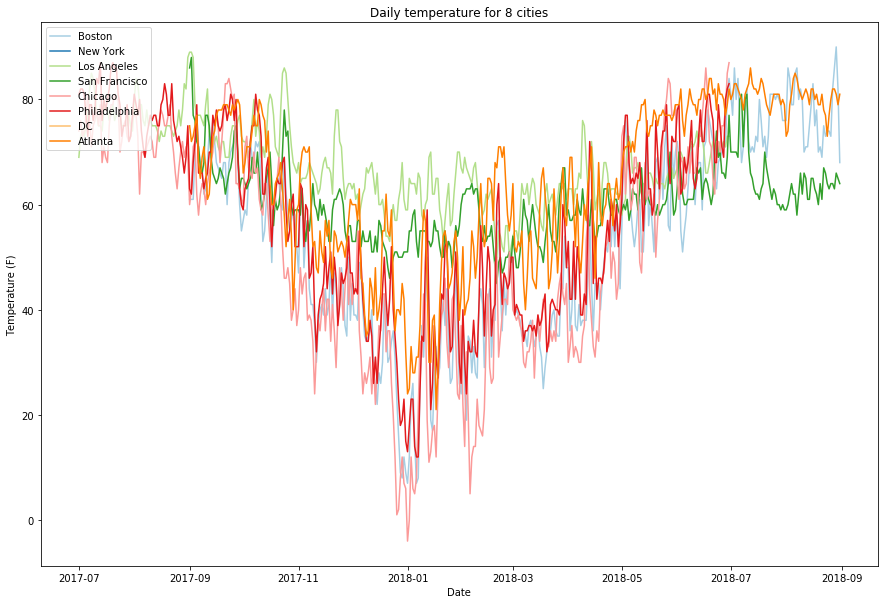

In [29]:
plt.figure(figsize=(15,10))
legend = []
for city, city_name in city_codes.items():
    df_city = df_daily[df_daily['City'] == city]
    plt.plot(df_city['Start Date'], df_city['temp_avg'])
    legend.append(city_name)

ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (F)")
ax.set_title("Daily temperature for 8 cities")
plt.legend(legend, loc='upper left');


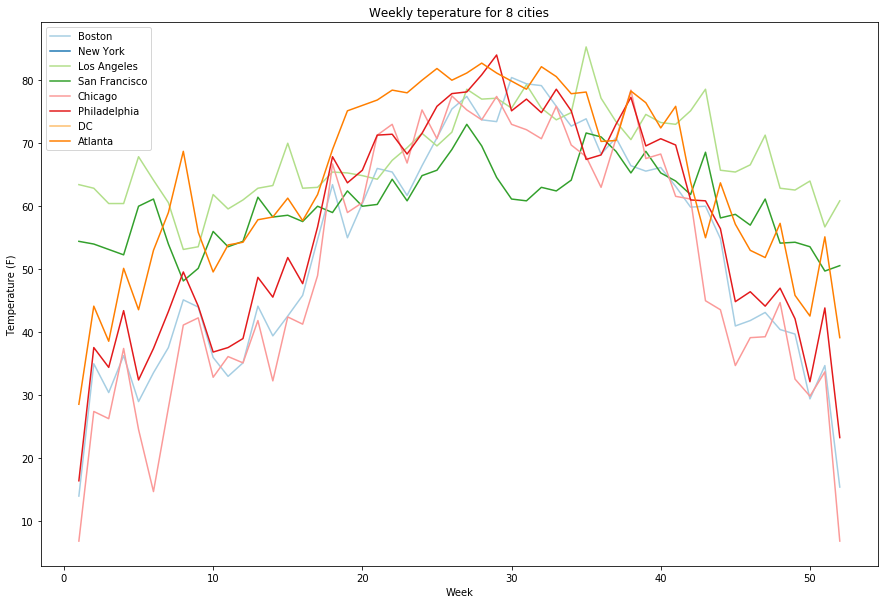

In [30]:
plt.figure(figsize=(15,10))
legend = []
for city, city_name in city_codes.items():
    df_city = df_week[df_week['City'] == city]
    plt.plot(df_city['Week'], df_city['Avg Temp'])
    legend.append(city_name)

ax = plt.gca()
ax.set_xlabel("Week")
ax.set_ylabel("Temperature (F)")
ax.set_title("Weekly teperature for 8 cities")
plt.legend(legend, loc='upper left');


<hr>
<a name="future"></a>

## <span style='color:#3b748a'>VII. Further work.</span>

<hr>
<a name="store"></a>

## <span style='color:#3b748a'>VIII. For future reference.</span>